In [ ]:
!pip install dostoevsky
!python -m dostoevsky download fasttext-social-network-model

In [62]:
import re

import pandas as pd
import numpy as np

import os.path
import warnings

import nltk
from nltk.corpus import stopwords

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

warnings.filterwarnings('ignore')

from dostoevsky.tokenization import RegexTokenizer
from dostoevsky.models import FastTextSocialNetworkModel

parent_dir = os.path.dirname(os.getcwd())

In [29]:
posts_df = pd.read_csv(os.path.join(parent_dir, "datasets/posts.csv"))
posts_df["tag"] = posts_df["text"].apply(lambda x: str(x).split("Подслушано")[-1].replace("\r\n\r\n#", "") if len(str(x).split("Подслушано")) > 1 else None)
posts_df["text"] = posts_df["text"].apply(lambda x: str(x).split("Подслушано")[0])
posts_df["tag"] = posts_df["tag"].apply(lambda x: str(x).replace("@overhear", "").replace("\r", "").replace("\n", " ").replace("_", ""))
posts_df["text"] = posts_df["text"].apply(lambda x: str(x).replace("\r", "").replace("\n", " ").replace("\t", " "))
posts_df.head()

,id,text,likes,reposts,views,tag
0,1632037,Однажды делал своей девушке куни. В самый моме...,19,34,5518,пошлое
1,1632031,Живу с молодым человеком и его мамой (временна...,369,64,53145,провал
2,1632022,"Всегда презирала проституток, порноактрис. А п...",167,47,27266,None
3,1632004,"Подруга полгода пролежала в коме после аварии,...",307,184,71438,пиздец
4,1631999,"Когда вернулся из армии, моя бабушка умерла и ...",820,9,97900,успех


In [58]:
def clean_data(text: str) -> str:
    """Очистка данных."""
    letters_only = re.sub("[^а-яА-Яa-zA-Z]", " ", text)
    lowercase_text = letters_only.lower()
    no_stop_words = []
    for word in lowercase_text.split():
        if word not in set(stopwords.words("russian")):
            no_stop_words.append(word)
    return " ".join(no_stop_words)

In [34]:
clean_posts = posts_df.copy()
clean_posts["text"] = clean_posts["text"].apply(clean_data)

Модель Достоевский

In [ ]:
tokenizer = RegexTokenizer()
dostoevsky_model = FastTextSocialNetworkModel(tokenizer=tokenizer)

text_posts = posts_df["text"].to_list()
results = dostoevsky_model.predict(text_posts)

In [42]:
dostoevsky_posts = posts_df[["id"]]
emotions = []
for res in tqdm(results):
    max_estimation = 0
    emotion = ""
    for emotion_, estimation_ in res.items():
        if emotion_ in ["negative", 'positive', 'neutral'] and max_estimation < estimation_:
            emotion = emotion_
            max_estimation = estimation_
    emotions.append(emotion)
dostoevsky_posts["emotion"] = emotions

100%|██████████| 87994/87994 [00:00<00:00, 483490.06it/s]


In [43]:
dostoevsky_posts.head()

,id,emotion
0,1632037,negative
1,1632031,neutral
2,1632022,neutral
3,1632004,positive
4,1631999,negative


In [45]:
dostoevsky_posts.to_csv(os.path.join(parent_dir, "results/dostoevsky_emotions.csv"), index=False)

<AxesSubplot:xlabel='emotion', ylabel='count'>

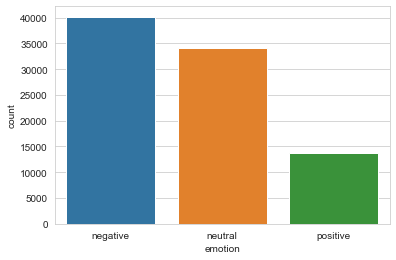

In [46]:
sns.countplot(x="emotion", data=dostoevsky_posts)

Модель кластеризации

<AxesSubplot:xlabel='emotion', ylabel='count'>

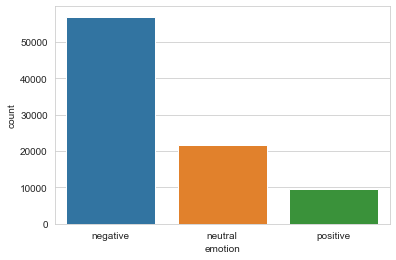

In [48]:
clustering_df = pd.read_csv(os.path.join(parent_dir, "results/clustering.csv"))
clustering_df.loc[clustering_df["cluster"] == 0, "emotion"] = "neutral"
clustering_df.loc[clustering_df["cluster"] == 1, "emotion"] = "positive"
clustering_df.loc[clustering_df["cluster"] == 2, "emotion"] = "negative"

sns.countplot(x="emotion", data=clustering_df)

In [52]:
np.sum(clustering_df["emotion"] == dostoevsky_posts["emotion"])

34031

Модель, обученная на маркированных данных

In [53]:
labeled_data = pd.read_json(os.path.join(parent_dir, "datasets/labeled_train_data.json"))
labeled_data.head()

,text,id,sentiment
0,Досудебное расследование по факту покупки ЕНПФ...,1945,negative
1,Медики рассказали о состоянии пострадавшего му...,1957,negative
2,"Прошел почти год, как железнодорожным оператор...",1969,negative
3,По итогам 12 месяцев 2016 года на территории р...,1973,negative
4,Астана. 21 ноября. Kazakhstan Today - Агентств...,1975,negative


In [55]:
labeled_data.shape

(8263, 3)

In [59]:
cleaned_labeled_data = labeled_data[["text", "sentiment"]]
cleaned_labeled_data["text"] = cleaned_labeled_data["text"].apply(clean_data)

In [63]:
classification_pipeline = Pipeline([
            ('vect', CountVectorizer(ngram_range=(1,2), analyzer="word")),
            ('tfidf', TfidfTransformer(use_idf=True)),
            ('model', LogisticRegression(solver="lbfgs", multi_class="multinomial")),
        ])

In [64]:
le = LabelEncoder()
le.fit(cleaned_labeled_data["sentiment"])
le.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

In [ ]:
cleaned_labeled_data["sentiment"] = le.transform(cleaned_labeled_data["sentiment"])

In [69]:
cleaned_labeled_data["sentiment"].head()

0    0
1    0
2    0
3    0
4    0
Name: sentiment, dtype: int32

In [75]:
X = cleaned_labeled_data["text"]
y = cleaned_labeled_data["sentiment"]

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

In [71]:
classification_pipeline.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('model', LogisticRegression(multi_class='multinomial'))])

In [72]:
accuracy_score(y_test, classification_pipeline.predict(X_test))

0.6972410454985479

In [74]:
print(classification_report(y_test, classification_pipeline.predict(X_test), target_names=le.classes_, digits=5))

              precision    recall  f1-score   support

    negative    0.77525   0.43546   0.55767       705
     neutral    0.66799   0.82759   0.73927      2030
    positive    0.73219   0.63994   0.68296      1397

    accuracy                        0.69724      4132
   macro avg    0.72514   0.63433   0.65997      4132
weighted avg    0.70800   0.69724   0.68925      4132



In [76]:
classification_pipeline.fit(X, y)

Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('model', LogisticRegression(multi_class='multinomial'))])

In [78]:
classification_result = classification_pipeline.predict(clean_posts["text"])

In [79]:
logistic_regression_df = clean_posts[["id"]]
logistic_regression_df["emotion"] = classification_result
logistic_regression_df["emotion"] = le.inverse_transform(logistic_regression_df["emotion"])

<AxesSubplot:xlabel='emotion', ylabel='count'>

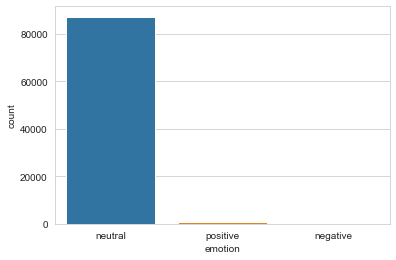

In [80]:
sns.countplot(x="emotion", data=logistic_regression_df)

In [81]:
logistic_regression_df.to_csv(os.path.join(parent_dir, "results/logistic_regression_results.csv"), index=False)